<a href="https://colab.research.google.com/github/QasimKhan5x/GDELT-AQL-NetworkX-Agent/blob/main/GDELT_OpenIntelligence_ReWOO_GraphRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GDELT Open Intelligence GraphRAG Agent

## Environment Setup & Connecting to ArangoGraph

In [ ]:
!pip install nx-arangodb --quiet
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com --quiet
!pip install adbnx-adapter --quiet
!pip install git+https://github.com/arangoml/langchain.git@master#subdirectory=libs/community --quiet
!pip install --upgrade langchain-openai langchain-anthropic langgraph --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia

In [ ]:
# Turn on cugraph networkx acceleration
%env NX_CUGRAPH_AUTOCONFIG=True

# Standard library imports
import os
import traceback
import re
import json
import base64
import asyncio
from datetime import datetime
from random import randint
from pprint import pprint
import pickle
from typing import List, Tuple, Union, Literal
from typing_extensions import TypedDict
from collections import defaultdict

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient
from arango.exceptions import AQLQueryExecuteError
from adbnx_adapter import ADBNX_Adapter
from pydantic import BaseModel, Field
from IPython.display import Image, display
from pydantic import BaseModel, Field
from dotenv import load_dotenv

# LangChain and LangGraph imports
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_community.graphs import ArangoGraph
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.messages.tool import ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END

nx.config.warnings_to_ignore.add("cache")

env: NX_CUGRAPH_AUTOCONFIG=True


[14:48:56 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


Create `.env` file with

```
ARANGODB_CERTIFICATE=
ARANGODB_PASSWORD=
OPENAI_API_KEY=
```



In [ ]:
load_dotenv()

True

In [ ]:
# download certificate file to connect to the database
encodedCA = os.environ["ARANGODB_CERTIFICATE"]
try:
    file_content = base64.b64decode(encodedCA)
    with open("cert_file.crt", "w+") as f:
        f.write(file_content.decode("utf-8"))
except Exception as e:
    pprint(str(e))
    exit(1)

In [ ]:
# connect to ArangoGraph
client = ArangoClient(
    hosts="https://f2955cea306d.arangodb.cloud:18529", verify_override="cert_file.crt"
)
db = client.db("_system", username="root", password=os.environ["ARANGODB_PASSWORD"], verify=True)

In [ ]:
# Initially, use ArangoDB to NetworkX adapter to convert the graph to native NetworkX class
# adbnx_adapter = ADBNX_Adapter(db)
# G_nx = adbnx_adapter.arangodb_graph_to_networkx("OPEN_INTELLIGENCE")

with open("/content/drive/MyDrive/gdelt.pickle", "rb") as f:
    G_nx = pickle.load(f)

arango_graph = ArangoGraph(db)

In [ ]:
# Create analyzers for ArangoSearch tools
for analyzers in db.analyzers():
    # to split by "_" and convert to lowercase
    if analyzers["name"] == "_system::norm_delimiter":
        print("norm_delimiter analyzer exists.")
        break
else:
    db.create_analyzer("norm_delimiter", analyzer_type="pipeline", properties={"pipeline": [
        { "type": "norm", "properties": { "locale": "en", "case": "lower" } },
        { "type": "delimiter", "properties": { "delimiter": "_" } },
    ]})

for analyzers in db.analyzers():
    # for geo-coordinates
    if analyzers["name"] == "_system::geojson":
        print("geojson analyzer exists.")
        break
else:
    db.create_analyzer("geojson", "geojson", {}, [])

norm_delimiter analyzer exists.
geojson analyzer exists.


In [ ]:
def get_graph_schema_json(G):
    """
    Extracts the schema of a graph and returns it as a structured JSON object.
    Captures unique node types, their attributes, and unique edge relationships.
    Also includes an example value from the graph for each node type.
    """
    node_types = defaultdict(lambda: {"attributes": set(), "example_value": None})  # Store attributes and example values
    edge_types = defaultdict(set)

    # Extract node attributes and an example value
    for node, attrs in G.nodes(data=True):
        node_type = node.split('/')[0] if '/' in node else "Unknown"
        node_types[node_type]["attributes"].update(attrs.keys())
        if node_types[node_type]["example_value"] is None and attrs:
            if node_type == "Event" and "description_embedding" in attrs:
                attrs["description_embedding"] = attrs["description_embedding"][:3]
                attrs["description_embedding"] = [round(value, 4) for value in attrs["description_embedding"]]
            node_types[node_type]["example_value"] = attrs

    # Extract edge relationships and add edge names
    for u, v, attrs in G.edges(data=True):
        u_type = u.split('/')[0] if '/' in u else "Unknown"
        v_type = v.split('/')[0] if '/' in v else "Unknown"

        # Extract edge collection name from _id (substring before '/')
        edge_name = attrs.get("_id", "Unknown/").split('/')[0] if "_id" in attrs else "UnknownEdge"

        edge_key = (edge_name, v_type, tuple(sorted(attrs.keys())))  # Use tuple to maintain order and avoid duplicates
        edge_types[u_type].add(edge_key)  # Store unique edges

    # Convert sets to lists for JSON compatibility
    schema_json = {
        "node_collections": {
            node_type: {
                "attributes": sorted(attributes["attributes"]),
                "example_value": attributes["example_value"]
            }
            for node_type, attributes in node_types.items()
        },
        "edge_collections": [
            {
                "name": edge_name,
                "source": src_type,
                "target": dest_type,
                "attributes": sorted(edge_attrs) if edge_attrs else []
            }
            for src_type, edges in edge_types.items()
            for edge_name, dest_type, edge_attrs in sorted(edges)
        ]
    }

    return schema_json

In [ ]:
# Get schema of G_nx to help the LLM with RAG
graph_schema_nx = get_graph_schema_json(G_nx)
graph_schema_nx_string = json.dumps(graph_schema_nx)
graph_schema_nx_string += """
DISTINCT Class._id: ['Class/Abduction_forced_disappearance', 'Class/Agreement', 'Class/Air_drone_strike', 'Class/Armed_clash', 'Class/Arrests', 'Class/Attack', 'Class/Battles', 'Class/Change_to_group_activity', 'Class/Chemical_weapon', 'Class/Disrupted_weapons_use', 'Class/Excessive_force_against_protesters', 'Class/Explosions_Remote_violence', 'Class/Government_regains_territory', 'Class/Grenade', 'Class/Headquarters_or_base_established', 'Class/Looting_property_destruction', 'Class/Mob_violence', 'Class/Non-state_actor_overtakes_territory', 'Class/Non-violent_transfer_of_territory', 'Class/Other', 'Class/Peaceful_protest', 'Class/Protest_with_intervention', 'Class/Protests', 'Class/Remote_explosive_landmine_IED', 'Class/Riots', 'Class/Sexual_violence', 'Class/Shelling_artillery_missile_attack', 'Class/Strategic_developments', 'Class/Suicide_bomb', 'Class/Violence_against_civilians', 'Class/Violent_demonstration']
DISTINCT Country._id: ['Country/Algeria', 'Country/Angola', 'Country/Benin', 'Country/Botswana', 'Country/Burundi', 'Country/Cameroon', 'Country/Central_African_Republic', 'Country/Chad', 'Country/Democratic_Republic_of_Congo', 'Country/Djibouti', 'Country/Equatorial_Guinea', 'Country/Eritrea', 'Country/Ethiopia', 'Country/Gabon', 'Country/Gambia', 'Country/Ghana', 'Country/Guinea', 'Country/Ivory_Coast', 'Country/Kenya', 'Country/Lesotho', 'Country/Liberia', 'Country/Republic_of_Congo']
DISTINCT Region._id: ['Region/Eastern_Africa', 'Region/Middle_Africa', 'Region/Northern_Africa', 'Region/Southern_Africa', 'Region/Western_Africa']
""".strip()

len(graph_schema_nx_string)

4294

## Embedding Event Descriptions for Vector Similarity Search

In [ ]:
!pip install -U sentence-transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.6 MB/s eta 0:00:00


In [ ]:
!pip install datashader bokeh holoviews scikit-image --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 100.9 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer

# Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-mpnet-base-v2").cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Iterate over nodes that contain "Event" in the name
event_nodes = [node for node in G_nx.nodes if "Event" in node]
event_descriptions = [G_nx.nodes[node]["description"] for node in event_nodes]
event_labels = np.array([G_nx.nodes[node]["label"] for node in event_nodes])
event_keys = np.array([G_nx.nodes[node]["_key"] for node in event_nodes])
len(event_nodes)

65534

In [ ]:
# convert event descriptions to vector embeddings
embeddings = model.encode(event_descriptions)
embeddings.shape

(65534, 768)

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/di

<Axes: >

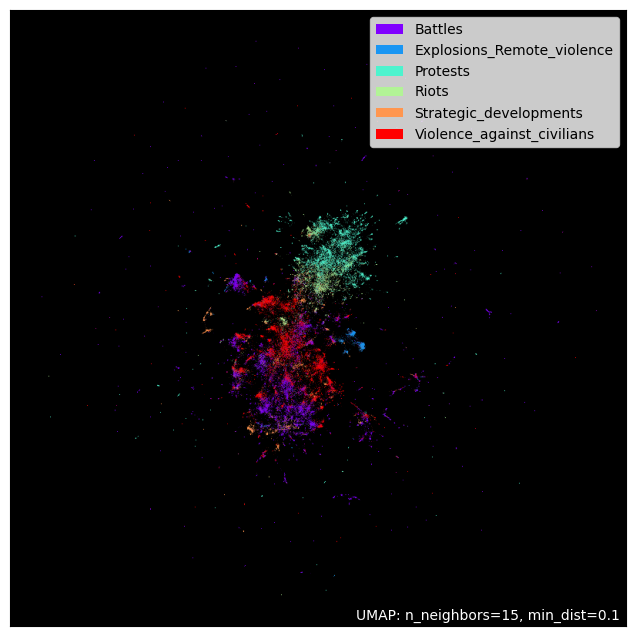

In [ ]:
import umap
import umap.plot

# fit a umap model to reduce and visualize the embeddings
mapper = umap.UMAP().fit(embeddings)
umap.plot.points(mapper, labels=event_labels, theme="fire")

In [ ]:
event_embeddings = {key: embedding for key, embedding in zip(event_keys, embeddings)}

# Convert to list of update statements
updates = [
    {"_key": _id, "description_embedding": embedding.tolist()}
    for _id, embedding in event_embeddings.items()
]

In [ ]:
from tqdm.notebook import tqdm

BATCH_SIZE = 1000
errors = []

# Process in batches
for i in tqdm(range(0, len(updates), BATCH_SIZE), desc="Updating Events in Batches"):
    batch = updates[i : i + BATCH_SIZE]

    try:
        query = """
        FOR doc IN @batch
            UPDATE { _key: doc._key }
            WITH { description_embedding: doc.description_embedding }
            IN Event
        """
        db.aql.execute(query, bind_vars={"batch": batch})
    except Exception as e:
        print(f"Error in batch {i // BATCH_SIZE + 1}: {e}")
        errors.extend(batch)  # Store failed updates for retry

print("Batch updates completed.")

**Add vector index in Arango Web UI**

or, use `arangosh`

```
db.Event.ensureIndex({
    name: "vector_cosine",
    type: "vector",
    fields: ["description_embedding"],
    params: { metric: "cosine", dimension: 768, nLists: 100 }
})
```

I am using ArangoGraph, but in version 3.12 of ArangoDB, the vector index is still an experimental option only available for the ArangoDB server. So, vector similarity searches will require full collection scans using cosine similarity.


## Agent

In [ ]:
# download custom ArangoGraphQAChain implementation
!wget https://raw.githubusercontent.com/QasimKhan5x/GDELT-AQL-NetworkX-Agent/refs/heads/main/arangodb.py

--2025-03-09 14:49:32--  https://raw.githubusercontent.com/QasimKhan5x/GDELT-AQL-NetworkX-Agent/refs/heads/main/arangodb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10912 (11K) [text/plain]
Saving to: ‘arangodb.py’

arangodb.py         100%[===================>]  10.66K  --.-KB/s    in 0s      

2025-03-09 14:49:33 (114 MB/s) - ‘arangodb.py’ saved [10912/10912]



In [ ]:
# custom ArangoGraphQAChain to prevent both query execution and explanation
from arangodb import ArangoGraphQAChain

### Definition of Structured Models and Graph State

The Planner model generates a `ReWOOPlan` which consists of a list of `Step` objects, each of which is individually passed to a worker node to execute.

The overall state of the graph is encapsulated in `ReWOO_State`

In [ ]:
class Step(BaseModel):
    """Represents a single step in the reasoning and retrieval process."""

    description: str = Field(..., description="A brief explanation of the purpose of this step.")
    tool: Literal["Text2AQL_Read", "Text2AQL_Write" ,"Text2NetworkX", "Text2Redirect", "Text2ArangoSearch", "Text2GeospatialSearch", "Text2SemanticSearch"] = Field(..., description="The external tool used for this step.")
    tool_input: str = Field(..., description="The instructions provided to the selected tool as input.")
    evidence_variable: str = Field(..., description="A reference variable (e.g., _E1, _E2) storing the output of this step for later use.")

    def __str__(self):
        """Returns the JSON representation of the object."""
        return json.dumps(self.model_dump(), indent=2)

class ReWOOPlan(BaseModel):
    """Structured plan for solving a given task using step-by-step reasoning and external tools."""

    plan: List[Step] = Field(..., description="A sequence of structured steps to solve the task efficiently.")

    def __iter__(self):
        for step in self.plan:
            yield step

    def __getitem__(self, key):
        return self.plan[key]

    def __len__(self):
        return len(self.plan)

class ReWOO_State(TypedDict):
    # current step to execute of the plan
    current_step: int
    # user query
    task: str
    # plan generated by planner
    plan: ReWOOPlan
    # intermediate tool call results
    tool_results: dict
    # code generated by each tool
    code_results: list[str]
    # final answer generated by generator
    answer: str
    # history of messages between user and chatbpt
    history: list[str]

### Tools

In [ ]:
# to generate final answers quickly
llm_fast = ChatOpenAI(
    model="gpt-4o-mini",
    max_tokens=None,
    max_retries=3,
)
# for code generation
llm = ChatOpenAI(
    model="gpt-4o",
    max_tokens=None,
    max_retries=3,
)
# to create the initial plan to solve the objective
llm_planner = ChatOpenAI(
    model="o3-mini",
    max_tokens=None,
    max_retries=3,
)

#### Planner Model

In [ ]:
planner_prompt = PromptTemplate.from_template("""
You are an AI planner that breaks down complex user queries over the ArangoDB graph database into structured steps while efficiently using available tools.
For the given task, generate a step-by-step plan with the absolute minimum number of steps required such that it:
1. Decomposes the problem into simple, logical steps.
2. Selects the appropriate tool and provide tool input using precise instructions and algorithmic vocabulary which is completely unambiguous.
3. Ensures that each step depends logically on prior evidence if applicable.
4. Merge at most two small actions (e.g., "finding events" + "filtering on a date") into a single step whenever possible.
  4.1. DO NOT create one step to retrieve all paths and another to filter for the shortest path.
  4.2. Instead, use a single step to retrieve the shortest paths directly.
5. Do NOT assign more than two tasks to a single tool call because it increases the chance of errors.
6. Do NOT provide Cypher as input to the tools! Always provide a precise structured English instruction
7. For intermediate instructions, always return the _id of the documents so that they can be used in subsequent steps.

The schema of the graph is provided below.
```
{schema}
```
If edge is described as
```
{{'name': 'eventActor', 'source': 'Event', 'target': 'Actor',
'attributes': ['_from', '_id', '_key', '_to']}}
```
That means Actor does INBOUND traversal and Event does OUTBOUND traversal. Actor cannot do OUTBOUND traversal and Event cannot do INBOUND traversal

Tools can be one of the following:
Below are concise descriptions for each tool, 1–2 sentences each:
1. Text2AQL_Read[text]: Generates AQL read queries for structured data retrieval from the knowledge graph. Used for numeric/date filters, grouping, sorting, lookups, and graph path traversals using known fields.
2. Text2AQL_Write[text]: Generates AQL write queries to modify the knowledge graph (create, update, or delete data). Use this for any data modification operations.
3. Text2NetworkX[text]: Generates graph analytics operations (e.g., centrality, shortest paths) in NetworkX. Can also execute short Python scripts if more advanced logic is required.
4. Text2Redirect[text]: Handles casual/off-topic user inputs. Gently redirects the user to focus on the knowledge graph domain.
5. Text2ArangoSearch[text]: Generates ArangoSearch queries for text-based filtering/ranking (like partial/fuzzy matches, BM25). Use whenever the user wants to find events containing certain words/phrases in text fields.
6. Text2GeospatialSearch[text]: Generates AQL geospatial queries for distance or region-based location filtering. Use if the user asks for events near a certain point or within a radius.
7. Text2SemanticSearch[text]: Generates AQL vector similarity searches for semantic matching. Use if the user wants conceptually similar events (e.g. "find events similar to...").

<example>
Task: Find the locations of the top 3 central violent events in Northern Africa between 2018 and 2020.
Plan: Find all events between 2018 and 2020, whose label contains "violence" and are connected to Northern Africa.
_E1 = Text2AQL_Read["Return all event IDs where location is reachable to region = "Northern Africa",
dates lying between 2018-2020, lower(label) contains 'violence'"]
Plan: Compute the degree centrality of the graph and then select the Event nodes in _E1 with the highest centrality score.
_E2 = Text2NetworkX["Compute graph centrality, filter the centralities to event nodes in _E1,
sort by descending order of centrality, return event IDs of top 3"]
Plan: Find the locations of the events from their event IDs in _E2
_E3 = Text2AQL_Read["Return the location ID and name of the events in _E2"]

Three steps were used here because the task involves AQL for querying, NetworkX for degree centrality, and AQL again for location retrieval.
</example>

<example>
Task: Which actor has the highest degree centrality in the entire graph?
Plan: Calculate the degree centrality of each Actor in the entire graph and identify the actor with the highest score.
_E1 = Text2NetworkX["Compute graph degree centrality, select the Actor node with the highest centrality score among Actor nodes, return Actor's ID and name."]

One step was used here because the task only involves NetworkX for degree centrality.
</example>

<example>
Task: Find the shortest path between the top 3 most influential actors in terms of betweenness centrality.
Plan: Compute the betweenness centrality of all Actor nodes and select the top 3 actors with the highest score.
_E1 = Text2NetworkX["Compute betweenness centrality for all Actor nodes, sort in descending order, filter top 3 actors, return their IDs."]
Plan: Find the shortest paths between the 3 selected actors in _E1 and return the paths.
_E2 = Text2NetworkX["Return list of lists containing the shortest paths between the actors in _E1."]

Two steps were used here because we want to avoid delegating excessive tasks to one tool for a single instruction.
</example>

<example>
Task: Find events from 2020 mentioning "kidnapping" in Eastern African countries in their event descriptions, and then show me the top 5 most countries with the highest number of such events.
Plan: Search for all events that mention "kidnapping" in their descriptions, confirm they are in Eastern Africa via a graph traversal, and count how many times each country appears.
_E1 = Text2ArangoSearch["Search the event descriptions for 'kidnapping', perform OUTBOUND traversal to confirm each event's country is in Region/Eastern_Africa, filter the date to 2020, and return the event IDs and associated country."]
Plan: Using _E1, we will group by country, sort by the highest count, and pick the top five countries.
_E2 = Text2AQL_Read["GROUP the events from _E1 by country, ORDER by count DESC, then RETURN the name and event count of the top 5."]

Two steps were used here because the first step is an ArangoSearch-based text retrieval plus graph check, and the second step is a simple aggregator with AQL reads.
</example>

Now generate a plan for the user's latest task in the given chat history: {task}
Your Plan:
""".strip(), partial_variables={"schema": graph_schema_nx_string})

planner_chain = planner_prompt | llm_planner.with_structured_output(ReWOOPlan)

#### Worker Tools

First, we define some utility functions that

*   Summarize the schema of a `json` element and provide an example value for the code generation
*   Check if the result of a tool contains null values, so that we retry that tool



In [ ]:
def summarize_schema(key, value, length=500):
    """
    Convert `value` to json, take a substring, and summarize its schema using an LLM.
    """
    value_s = json.dumps(value)
    value_s = value_s[:length]
    if not value_s.endswith("}"):
        # Find the index of the last }]
        index = value_s.rfind("}")
        # Crop till this index
        value_s = value_s[: index + 1]
        if value_s.startswith("["):
            value_s += "]"

    prompt = f"""
    Please summarize the schema of the following data as a Python TypedDict.

    **Instructions:**
    - Only output the Python code for a `TypedDict` that captures the keys and their types.
    - Assume the data is a **list of dictionaries** and name the TypedDict accordingly.
    - Include an example of multiple elements in the list as a comment.
    - Ensure the types are inferred correctly.

    **Example:**
    If the data is:
    ```json
    [
        {{"eventId": "Event/ALG1", "description": "5 January: some event", "sourceName": "Algeria Watch"}},
        {{"eventId": "Event/ALG2", "description": "10 February: another event", "sourceName": "BBC News"}},
        {{"eventId": "Event/ALG3", "description": "15 March: yet another event", "sourceName": "Reuters"}}
    ]
    ```

    The output should be:
    ```python
    class _E1_Item(TypedDict):
        eventId: str  # Example: "Event/ALG1"
        description: str  # Example: "5 January: some event"
        sourceName: str  # Example: "Algeria Watch"

    _E1: List[_E1_Item]
    # Example: _E1 = [{{"eventId": "Event/ALG1", "description": "5 January: some event", "sourceName": "Algeria Watch"}},]
    ```

    Now, please produce a TypedDict for the following data:
    ```json
    {key} = {value_s}
    ```
    """

    summary = llm.invoke(prompt).content
    schema = re.sub(r"^```python\n|```$", "", summary, flags=re.MULTILINE).strip()

    return schema

In [ ]:
def contains_null(data):
    """
    Recursively checks if a JSON-like object contains None anywhere inside it.

    Args:
        data (any): JSON-like data (dict, list, etc.)

    Returns:
        bool: True if None is found, False otherwise.
    """
    if data is None:
        return True
    if isinstance(data, dict):
        return any(contains_null(value) for value in data.values())
    if isinstance(data, list):
        return any(contains_null(item) for item in data)
    return False  # Base case for other types (int, str, bool, float)

We have 7 tools:

1. `Text2AQL_Read[text]`: Generates AQL read queries for structured data retrieval from the knowledge graph. Used for numeric/date filters, grouping, sorting, lookups, and graph path traversals using known fields.
2. `Text2AQL_Write[text]`: Generates AQL write queries to modify the knowledge graph (create, update, or delete data). Use this for any data modification operations.
3. `Text2NetworkX[text]`: Generates graph analytics operations (e.g., centrality, shortest paths) in NetworkX. Can also execute short Python scripts if more advanced logic is required.
4. `Text2Redirect[text]`: Handles casual/off-topic user inputs. Gently redirects the user to focus on the knowledge graph domain.
5. `Text2ArangoSearch[text]`: Generates ArangoSearch queries for text-based filtering/ranking (like partial/fuzzy matches, BM25). Use whenever the user wants to find events containing certain words/phrases in text fields.
6. `Text2GeospatialSearch[text]`: Generates AQL geospatial queries for distance or region-based location filtering. Use if the user asks for events near a certain point or within a radius.
7. `Text2SemanticSearch[text]`: Generates AQL vector similarity searches for semantic matching. Use if the user wants conceptually similar events (e.g. "find events similar to...").

`Text2ArangoSearch`, `Text2GeospatialSearch`, and `Text2SemanticSearch` are all simply variations of `Text2AQL_Read` with additional context and examples in the LLM prompt to correctly generate queries for these tools.




In [ ]:
def Text2AQL_Read(
    query: str,
    use_arango_search=False,
    use_geospatial_search=False,
    use_vector_search=False,
    **kwargs,
):
    """
    This tool is used to convert a natural language instruction (query) into an AQL query,
    execute it, and return the result.
    Query is a natural language sentence with the intention to read from the database.
    kwargs can contain some additional input to pass in the query.
    Always prefer to use this tool for reading from the database unless a graph algorithm or computation is required.
    """

    if use_arango_search:
        query += """\nInstructions: Search in event_view. If you search description, use "text_en" analyzer. If you search label, use "norm_delimiter" analyzer. If a word ends with a common suffix—such as 'violent' or 'violence', extract the stem ('violen') and prefer functions like STARTS_WITH(violen') instead of exact matches."""
    elif use_geospatial_search:
        example = """
// Example AQL query that finds all events within 10 km of Event/ALG1
LET referenceCoord = FIRST(
  FOR doc IN Event
    FILTER doc._id == "Event/ALG1"
    RETURN doc.geo
)
FOR ev IN event_view
  SEARCH ANALYZER(
    GEO_DISTANCE(ev.geo, referenceCoord) < 10000,
    "geojson"
  )
  LET distance = GEO_DISTANCE(ev.geo, referenceCoord)
  SORT distance
  RETURN {
    eventId: ev._id,
    geo: ev.geo,
    distance
  }
"""
        query += f"""\nInstructions: Do not use the `.geo` attribute from any collection except `event_view`.
If you need location-related data from other collections (e.g., `location`), you must only access it through path traversal from `event_view`.
Use "geojson" analyzer. Use the below query as a template to generate the answer:```{example}```"""
    elif use_vector_search:
        example = """
// Example AQL query that finds all top 3 events most semantically similar to Event/ALG1
LET refEmbedding = FIRST(
  FOR ref IN Event
    FILTER ref._id == "Event/ALG1"
    RETURN ref.description_embedding
)

FOR ev IN Event
  FILTER ev._id != "Event/ALG1"
  LET similarity = COSINE_SIMILARITY(ev.description_embedding, refEmbedding)
  SORT similarity DESC
  LIMIT 3
  RETURN {
    eventId: ev._id,
    similarity
  }
"""
        query += f"""\nInstructions: Use the below query as a template to generate the answer:```{example}```"""
    # Prepare instructions about previous output and its schema.
    previous_output = ""
    key, value = None, None
    if kwargs:
        key, value = list(kwargs.items())[0]
        if use_geospatial_search or use_vector_search:
            pattern = r"\b([A-Za-z]+/\w+)\b"
            # find first occurrence
            match = re.search(pattern, query)
            if match:
                value = match.group(1)
            else:
                return {"result": None, "script": ""}

        if isinstance(value, str):
            previous_output = (
                f"\nYou must use the variable `{key}` in your query. Its schema is as follows: str\n"
                f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema."
            )
        elif isinstance(value, int):
            previous_output = (
                f"\nYou must use the variable `{key}` in your query. Its schema is as follows: int\n"
                f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema."
            )
        elif isinstance(value, list) and all(isinstance(x, (str, int)) for x in value):
            if all(isinstance(x, str) for x in value):
                previous_output = (
                    f"\nYou must use the variable `{key}` in your query. Its schema is as follows: list[str]. Example of element inside `{key}`: {value[0]}\n"
                    f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema."
                )
            else:
                previous_output = (
                    f"\nYou must use the variable `{key}` in your query. Its schema is as follows: list[int]. Example of element inside `{key}`: {value[0]}\n"
                    f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema."
                )
        else:
            value_schema = summarize_schema(key, value)
            previous_output = (
                f"\nYou must use the variable `{key}` in your query. Its type is {type(value)} and schema is as follows: {value_schema}\n"
                f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema."
            )

    # Append the previous output instructions to the query.
    if previous_output:
        query += "\n" + previous_output

    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True,
    )
    chain.execute_aql_query = False

    max_attempts = 3
    attempts = 0
    aql = ""

    while attempts < max_attempts:
        result = chain.invoke(query)
        aql = result["result"]
        print(aql)
        if key:
            # replace the placeholder with the actual value
            if isinstance(value, str):
                executable_aql = aql.replace(f"{key}", f'"{value}"')
            else:
                executable_aql = aql.replace(f"{key}", f"{value}")
        else:
            executable_aql = aql

        try:
            aql_result = list(db.aql.execute(executable_aql))
        except AQLQueryExecuteError as e:
            attempts += 1
            # Append a note to inform the chain about previous failures.
            if attempts == 1:
                query += "\nThe following AQL samples generated an error or a logical bug. Please think step by step why the error occurred and generate fixed code that avoids these errors:\n"
            query += f"\nQuery:\n```{aql}```\nError:{e}"
            print(f"Attempt {attempts} failed; retrying with modified query.")
            print("Query to be used:", query)
            continue
        if aql_result and not contains_null(aql_result):
            # Filter each entry to only keep the '_id' where applicable.
            for i, entry in enumerate(aql_result):
                if isinstance(entry, dict):
                    if "_id" in entry:
                        # Replace the entire entry with its '_id'
                        aql_result[i] = entry["_id"]
                    else:
                        # For each key, if the value is a dict with an '_id', replace it with that '_id'
                        new_entry = {}
                        for key, value in entry.items():
                            if isinstance(value, dict) and "_id" in value:
                                new_entry[key] = value["_id"]
                            else:
                                new_entry[key] = value
                        aql_result[i] = new_entry
            return {"result": aql_result, "script": aql}
        else:
            attempts += 1
            # Append a note to inform the chain about previous failures.
            if attempts == 1:
                query += "\nThe following AQL samples generated an error or a logical bug. Please think step by step why the error occurred and generate fixed code that avoids these errors:\n"
            if aql_result:
                aql_result = str(aql_result)[:200]
            query = (
                query
                + f"\nQuery (returned empty results or null values): \n```{aql}```\n Output snippet: \n{aql_result}\n."
            )
            print(f"Attempt {attempts} failed; retrying with modified query.")
            print("Query to be used:", query)

    return {"result": None, "script": ""}

In [ ]:
def Text2AQL_Write(query: str):
    """
    This tool is used to convert a natural language instruction (query) into an AQL query,
    execute it, and return the result.
    Query is a natural language sentence with the intention to write into the database.
    Either the result of the query or an error message (based on moderator approval) is returned.
    """

    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True,
    )
    chain.execute_aql_query = False
    previous_aql = None
    tries = 0
    while True:
        try:
            result = chain.invoke(query)
            aql = result["result"]
            approval_prompt = f"""The following AQL query can modify data:\n{aql}\n
Type 'Y' to approve its execution.
Type 'N' to regenerate the query.
Any other input will cancel the operation:\n >>> """
            user_response = input(approval_prompt)
            if user_response.lower() == "y":
                result = list(db.aql.execute(aql))
                # first 5 for brevity
                return result[:5]
            elif user_response.lower() != "n":
                return "INFO: User cancelled query execution."
            else:
                if previous_aql is None:
                    query += f"\nThe user rejected the following queries, so do not generate any of the following:\n```{aql}```"
                    previous_aql = aql
                else:
                    query += f"\n```{aql}```"
        except Exception as e:
            tries += 1
            print(f"EXEC ERROR: {e}")
            if tries > 3:
                print(f"exiting")
                return f"EXEC ERROR: {e}"

In [ ]:
def Text2Redirect(query: str):
    """
    Invoke this tool for casual or off-topic user queries (e.g., greetings, chitchat, or unrelated questions),
    The GDELT Open Intelligence knowledge graph contains events in African countries, which actors committed them, or the sources of these events.
    Do not use this tool if the query mentions similar things.
    """
    print("Redirecting query...")
    return llm_fast.invoke(
        f"""
        The user has asked a casual or off-topic question: "{query}".

        Please generate a friendly and brief response that informs the user
        that this system is designed to answer questions about the GDELT Open Intelligence graph. Encourage
        the user to ask a graph-related question if they need assistance.

        Your response:
    """
    ).content

In [ ]:
def Text2NetworkX(query, **kwargs):
    """
    Executes a NetworkX algorithm on the ArangoDB Graph based on a natural language instruction.
    Avoid using this function for descriptive queries that can be solved using AQL.

    Parameters:
        query (str): The natural language graph analysis query.
        kwargs: Additional inputs to pass into the query.
    """
    max_attempts = 3
    failed_codes = []
    attempt = 0
    FINAL_RESULT = None
    # pass these instructions if max_attempts with cugraph backend failed
    backend_instructions = [
        "",
        "\nWhen executing any NetworkX algorithm that involves computation, always include `backend='networkx'`.",
    ]

    key, value = None, None
    previous_output = ""
    if kwargs:
        key, value = list(kwargs.items())[0]
        if isinstance(value, str):
            previous_output = (
                f"\nYou must use the variable `{key}` in your code. Assume it already exists in the code, so do not refine it - just manipulate it. "
                f"Its schema is as follows: str. "
                f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema.\n"
            )
        elif isinstance(value, int):
            previous_output = (
                f"\nYou must use the variable `{key}` in your code. Assume it already exists in the code, so do not refine it - just manipulate it. "
                f"Its schema is as follows: int. "
                f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema.\n"
            )
        elif isinstance(value, (list, tuple)) and all(
            isinstance(x, (str, int)) for x in value
        ):
            if all(isinstance(x, str) for x in value):
                previous_output = (
                    f"\nYou must use the variable `{key}` in your code. Assume it already exists in the code, so do not refine it - just manipulate it. "
                    f"Its schema is as follows: list[str]. "
                    f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema.\n"
                )
            else:
                previous_output = (
                    f"\nYou must use the variable `{key}` in your code. Assume it already exists in the code, so do not refine it - just manipulate it. "
                    f"Its schema is as follows: list[int]. "
                    f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema.\n"
                )
        elif isinstance(value, set) and all(isinstance(x, (str, int)) for x in value):
            if all(isinstance(x, str) for x in value):
                previous_output = (
                    f"\nYou must use the variable `{key}` in your code. Assume it already exists in the code, so do not refine it - just manipulate it. "
                    f"Its schema is as follows: set[str]. "
                    f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema.\n"
                )
            else:
                previous_output = (
                    f"\nYou must use the variable `{key}` in your code. Assume it already exists in the code, so do not refine it - just manipulate it. "
                    f"Its schema is as follows: set[int]. "
                    f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema.\n"
                )
        else:
            value_schema = summarize_schema(key, value)
            previous_output = (
                f"\nYou must use the variable `{key}` in your code. Assume it already exists in the code, so do not refine it - just manipulate it. "
                f"Its schema is as follows:\n```{value_schema}```\n"
                f"Ensure that all operations correctly interpret and manipulate `{key}` based on this schema.\n"
            )
    graph_object = "G_nx"

    while attempt < max_attempts * 2:
        print(f"\n[Text2NetworkX] Attempt {attempt + 1} of {max_attempts * 2}")
        backend_instruction = backend_instructions[attempt // max_attempts]

        failed_code_prompt = (
            "\nThe following code samples generated an error. Please think step by step why the error occurred and generate fixed code that avoids these errors:\n"
            + "\n".join(
                f"<failed_code_{i+1}>{code}</failed_code_{i+1}>"
                for i, code in enumerate(failed_codes)
            )
        )

        llm_input = f"""I have a NetworkX Graph called `{graph_object}`. It has the following schema: ```{graph_schema_nx_string}```

I have the following graph analysis query: {query}.

Generate the Python Code required to answer the query using the `{graph_object}` object.

{previous_output}

Be precise on the NetworkX algorithm selected to answer this query. Think step by step.

Only assume that networkx is installed and imported as `nx`, and other base python dependencies exist.
{backend_instruction}

To determine if a node or edge is of a specified type, verify that the type name is present in its _id field:
`"typeName" in x.get("_id", "")`

Only provide executable Python code (no explanations). Keep the code concise (less than 20 lines).

Whenever you create a temporary variable to store a new list, set, dict, or subgraph, check if it is non-empty, otherwise raise a ValueError with a helpful message.

If something can be done once, don't do it multiple times in a loop.

Always set the last variable as `FINAL_RESULT`, representing the answer to the original query.
Make sure `FINAL_RESULT` stores a short, concise answer. Avoid long sequences.
{failed_code_prompt}

Your code:
"""

        text_to_nx = llm.invoke(llm_input).content
        start_index = text_to_nx.find("```python")
        end_index = text_to_nx.rfind("```")
        text_to_nx = text_to_nx[start_index : end_index + 1]
        text_to_nx_cleaned = re.sub(
            r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE
        ).strip()
        text_to_nx_cleaned = text_to_nx_cleaned.replace("`", "")

        print("-" * 10, text_to_nx_cleaned, "-" * 10, sep="\n")
        print("\n2) Executing NetworkX code")

        global_vars = {"G_nx": G_nx, "nx": nx, key: value}

        try:
            exec(text_to_nx_cleaned, global_vars)
            FINAL_RESULT = global_vars.get("FINAL_RESULT")
            if not FINAL_RESULT:
                raise ValueError("FINAL_RESULT is empty or not set.")
            print("-" * 10, f"FINAL_RESULT: {FINAL_RESULT}", "-" * 10, sep="\n")
            return {"script": text_to_nx_cleaned, "result": FINAL_RESULT}
        except Exception as e:
            failed_code = (
                f"# Following script failed due to {traceback.format_exc()}\n"
                + text_to_nx_cleaned
            )
            print(failed_code)
            failed_codes.append(failed_code)
            attempt += 1
            if attempt == max_attempts // 2:
                # reset for networkx backend
                failed_codes = []

    print("All attempts failed.")
    return {"script": "", "result": None}

### Agent Graph

In [ ]:
def get_plan(state: ReWOO_State):
    "Obtain the plan to tackle the user's task"

    print(f"Generating plan...")
    task = state["task"]
    history = state["history"]
    history.append(task)
    # keep the last 3 messages only
    history = history[-3:]
    if len(history) == 3:
        # assuming the 1st message is user msg and second msg is AI msg
        task += f"""User: {history[0]}
        AI: {history[1]}
        User: {history[2]}
        """.strip()

    plan = planner_chain.invoke({"task": task})

    return {
        "plan": plan,
        "current_step": 0,
        "history": history,
        "tool_results": {},
        "code_results": [],
    }


def execute_tool(state: ReWOO_State):
    "Execute the tool in the current stop of the plan"

    plan = state["plan"]
    step_index = state["current_step"]
    tool_results = state["tool_results"]
    code_results = state["code_results"]

    step_to_execute = plan[step_index]
    tool = step_to_execute.tool
    tool_input = step_to_execute.tool_input
    evidence_variable = step_to_execute.evidence_variable

    if tool in (
        "Text2AQL_Read",
        "Text2ArangoSearch",
        "Text2GeospatialSearch",
        "Text2SemanticSearch",
    ):
        if step_index == 0:
            result = Text2AQL_Read(
                tool_input,
                use_arango_search=tool == "Text2ArangoSearch",
                use_geospatial_search=tool == "Text2GeospatialSearch",
                use_vector_search=tool == "Text2SemanticSearch",
            )
        else:
            previous_evidence_variable = plan[step_index - 1].evidence_variable
            result = Text2AQL_Read(
                tool_input,
                use_arango_search=tool == "Text2ArangoSearch",
                use_geospatial_search=tool == "Text2GeospatialSearch",
                use_vector_search=tool == "Text2SemanticSearch",
                **{
                    previous_evidence_variable: tool_results[previous_evidence_variable]
                },
            )
        tool_results[evidence_variable] = result["result"]
        code_results.append(result["script"])
    elif tool == "Text2NetworkX":
        if step_index == 0:
            result = Text2NetworkX(tool_input)
        else:
            previous_evidence_variable = plan[step_index - 1].evidence_variable
            result = Text2NetworkX(
                tool_input,
                **{
                    previous_evidence_variable: tool_results[previous_evidence_variable]
                },
            )
        tool_results[evidence_variable] = result["result"]
        code_results.append(result["script"])
    elif tool == "Text2Redirect":
        tool_results[evidence_variable] = Text2Redirect(tool_input)
    else:
        raise ValueError(f"Unknown tool: {tool}")

    return {
        "tool_results": tool_results,
        "current_step": step_index + 1,
        "code_results": code_results,
    }


def generate_answer(state: ReWOO_State):
    """
    Transforms the raw execution result from a NetworkX algorithm or AQL query into a natural language response.
    """

    history = state["history"]
    intermediate_results = state["tool_results"]
    result = list(intermediate_results.values())[-1]
    query = state["task"]

    print(f"Generating answer...")

    # shorten the results
    for key, value in intermediate_results.items():
        intermediate_results[key] = json.dumps(value)[:200]

    if not result:
        history.append("No answer found.")
        return {"answer": "No result found.", "history": history}

    def is_id(value):
        return isinstance(value, str) and len(value.split("/")) == 2

    # Case 1: result is a flat list of IDs
    if isinstance(result, list) and result and all(is_id(x) for x in result):
        aql_query = f"""FOR nodeId IN {json.dumps(result)}
    LET node = DOCUMENT(nodeId)
    RETURN node"""
        try:
            result = list(db.aql.execute(aql_query))[:10]
        except Exception as e:
            print(f"Error executing AQL query for flat IDs: {e}")

    # Case 2: result is a list of dicts with nested IDs
    elif isinstance(result, list) and all(isinstance(x, dict) for x in result):
        ids_set = {
            value for entry in result for value in entry.values() if is_id(value)
        }
        if ids_set:
            aql_query = f"""FOR nodeId IN {json.dumps(list(ids_set))}
    LET node = DOCUMENT(nodeId)
    RETURN node"""
            try:
                full_docs = list(db.aql.execute(aql_query))
                doc_map = {doc["_id"]: doc for doc in full_docs if "_id" in doc}
                for entry in result[:10]:
                    for key, value in entry.items():
                        if is_id(value):
                            entry[key] = doc_map.get(value, value)
            except Exception as e:
                print(f"Error executing AQL query for nested IDs: {e}")

    result_text = llm.invoke(
        f"""I have the following graph analysis query: {query}.

The intermediate execution results from the tool are as follows: \n```{intermediate_results}```.

The final answer obtained is as follows: \n```{result}```.

Based on the final answer as well as additional contextual details given by the intermediate execution results,
generate a succinct natural language answer that directly addresses all of the information requested in the query with sufficient details.
Use the intermediate execution results with caution since long evidence might contain irrelevant information.
Always mention the "_id" of individual nodes if they are available alongside a descriptive attribute like name, label, or description based on
what the user has requested.

Your response:
    """
    ).content
    history.append(result_text)

    return {"answer": result_text, "history": history}


def _route(state):
    current_step = state["current_step"]
    plan = state["plan"]
    intermediate_results = state["tool_results"]

    # reiterate if we haven't reached the end of the plan and
    # the result of the last executed step is not null
    if current_step < len(plan) and intermediate_results[f"_E{current_step}"]:
        return "tool"
    else:
        return "generate"

In [ ]:
graph = StateGraph(ReWOO_State)
graph.add_node("planning", get_plan)
graph.add_node("tool", execute_tool)
graph.add_node("generate", generate_answer)

graph.add_edge(START, "planning")
graph.add_edge("planning", "tool")
graph.add_edge("generate", END)
graph.add_conditional_edges("tool", _route, ["tool", "generate"])

# add persistence to refer to chat history
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

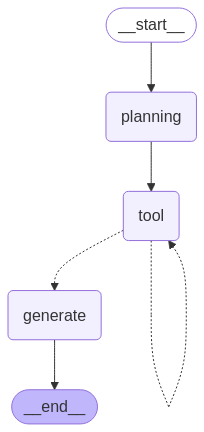

In [ ]:
import requests

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except (TimeoutError, requests.exceptions.ReadTimeout) as e:
    print("Connection to mermaid could not be established")

## Testing

In [ ]:
sample_queries = {
    "aql_only": "What major events occurred in Algeria in January 1997 and what nodes are the source of that information",
    "networkx_only": "Which actor has the highest degree centrality in the entire graph?",
    "hybrid1": "Find all events in Kenya labeled 'Battles' or 'Violence_against_civilians' between 2019-2020, then compute the top 3 central actors participating in those events.",
    "hybrid2": "Find the top 3 events in Algeria that have the highest average number of fatalities. Then compute the betweenness scores of actors involved in those events and return the actor with the highest one.",
    "hybrid3": "Find the events in Northern Africa labeled Violence_against_civilians between 2018 and 2020, and identify the shortest paths between the earliest one and the latest one.",
    "casual": "Tell me a random fun fact about cats!"
}

In [ ]:
query = sample_queries["hybrid1"]
config = {"configurable": {"thread_id": "1"}}

#
# response = app.invoke({"task": query}, config=config)
# print(response)

# stream response
for s in app.stream({"task": query, "history": []}, config=config):
    print(s)
    print("---")

Generating plan...
{'planning': {'plan': ReWOOPlan(plan=[Step(description="Retrieve all unique Actor _id values from events that meet the following criteria: the event date is between 2019 and 2020; the event label is either 'Battles' or 'Violence_against_civilians'; the event is located in Kenya (determined by traversing from Event to Location via 'hasLocation' and then from Location to Country via 'inCountry' with country _id 'Country/Kenya'); using the outbound traversal from Event via the 'eventActor' edge to reach Actor nodes. Return the event _id and subsequently the Actor _id for use in the next step.", tool='Text2AQL_Read', tool_input="Find all Event documents where the date is between '2019-01-01T00:00:00.000Z' and '2020-12-31T23:59:59.999Z', and where the label is either 'Battles' or 'Violence_against_civilians'. For these events, perform an outbound traversal using the 'hasLocation' edge to the Location node, then perform an outbound traversal on the 'inCountry' edge to the 

#

In [ ]:
query = "Find the top 3 events in Algeria that have the highest average number of fatalities. Then compute the betweenness scores of actors involved in those events and return the actor with the highest one.",
for s in app.stream({"task": query, "history": []}, config=config):
    print(s)
    print("---")

Generating plan...
{'planning': {'plan': ReWOOPlan(plan=[Step(description='Retrieve the top 3 events in Algeria based on their fatalities by traversing from Event to Location and ensuring the location is linked to Country/Algeria via the inCountry edge.', tool='Text2AQL_Read', tool_input="From the Event collection, traverse OUTBOUND via 'hasLocation' to the Location collection, then traverse OUTBOUND via 'inCountry' on Location to filter for Country with _id 'Country/Algeria'. Retrieve event _id and fatalities, order the events by fatalities in descending order, and return the top 3 event IDs.", evidence_variable='_E1'), Step(description='Collect the distinct actor IDs involved in the events found in _E1 by traversing the eventActor edge from Event to Actor.', tool='Text2AQL_Read', tool_input="For each event _id in _E1, traverse OUTBOUND using the 'eventActor' edge to retrieve the connected Actor nodes. Return the distinct Actor _id values.", evidence_variable='_E2'), Step(description=

### cuGraph Acceleration

The last query in the testing section involved the computation of betweenness centrality, which is an expensive operation over the entire graph. Let's check the difference between using the cuGraph acceleration vs. CPU only. For reference, I used the L4 GPU for this notebook.



First, let's recheck the code and results that the agent produced for us.

In [ ]:
state = app.get_state(config)

In [ ]:
_E2 = state.values["tool_results"]["_E2"]
print(state.values["code_results"][2])

# Filter Actor nodes using the _id values from _E2
actor_ids = [node for node in G_nx.nodes() if any(aid in node for aid in _E2)]

# Raise error if no actor nodes found
if not actor_ids:
    raise ValueError("No valid Actor nodes found in _E2")

# Check that all nodes in actor_ids are from Actor node collection
actor_nodes = [node for node in actor_ids if "Actor" in G_nx.nodes[node].get("_id", "")]

# Raise error if no Actor nodes matched from actor_ids
if not actor_nodes:
    raise ValueError("No Actor nodes found with the given _id values in the Actor collection")

# Compute betweenness centrality for those nodes
betweenness = nx.betweenness_centrality(G_nx, normalized=True, endpoints=False)

# Extract betweenness centrality for the actor nodes
actor_betweenness = {node: betweenness[node] for node in actor_nodes}

# Find the Actor with the highest betweenness centrality
if not actor_betweenness:
    raise ValueError("No betweenness centrality scores found for Actor nodes")

highest_a

Let's copy the line that computes betweenness centrality.

In [ ]:
%%time
# Compute betweenness centrality using cuGraph
betweenness_cugraph = nx.betweenness_centrality(G_nx, normalized=True, endpoints=False)

CPU times: user 1min 31s, sys: 19.2 s, total: 1min 50s
Wall time: 1min 49s


In [ ]:
wall_time_cugraph = 60 + 49

I tried to compute betweenness centrality using the CPU for the entire graph, but it took more than 3 hours and the computation was still not finished!

So, I will find the k-core of the graph (a subgraph where all nodes have a degree of atleast k). This will reduce the graph to a denser subgraph with a smaller number of nodes and less edges, but all remaining nodes will be densely connected so betweenness will still take a significant time to compute.

In [ ]:
# Set desired k value (higher k = denser subgraph)
K_CORE_VALUE = 5

# Compute k-core subgraph
G_kcore = nx.k_core(G_nx, k=K_CORE_VALUE).copy()
print("Original nodes and edges:", G_nx.number_of_nodes(), G_nx.number_of_edges())
print("K-core nodes and edges:", G_kcore.number_of_nodes(), G_kcore.number_of_edges())

Original nodes and edges: 80047 320630
K-core nodes and edges: 38810 181416


However, even with the 5-core (larger values of k produced an empty subgraph), the computation on the CPU does not finish in time before the session is disconnected.

Therefore, I will take a random sample of nodes from `G_kcore` and compute betweenness centrality there.

In [ ]:
import random

# Desired number of nodes for the sampled subgraph
SAMPLE_SIZE = 10000

# Ensure the graph is not empty
if len(G_nx) < SAMPLE_SIZE:
    raise ValueError("G_nx has fewer nodes than SAMPLE_SIZE. Choose a smaller value.")

# Sample nodes from G_nx
sampled_nodes = random.sample(list(G_kcore.nodes), SAMPLE_SIZE)

# Create subgraph
G_sub = G_nx.subgraph(sampled_nodes).copy()

G_sub.number_of_nodes(), G_sub.number_of_edges()

(10000, 10231)

In [ ]:
%%time
betweenness_cpu = nx.betweenness_centrality(G_sub, normalized=True, endpoints=False, backend="networkx")

CPU times: user 6min 44s, sys: 1.03 s, total: 6min 45s
Wall time: 6min 42s


In [ ]:
wall_time_cpu = 6 * 60 + 42

In [ ]:
%%time
# Compute betweenness centrality using cuGraph on G_sub for fair comparison
betweenness_cugraph = nx.betweenness_centrality(G_sub, normalized=True, endpoints=False)

CPU times: user 4.84 s, sys: 25.1 ms, total: 4.86 s
Wall time: 4.92 s


In [ ]:
wall_time_cugraph_sub = 4.92

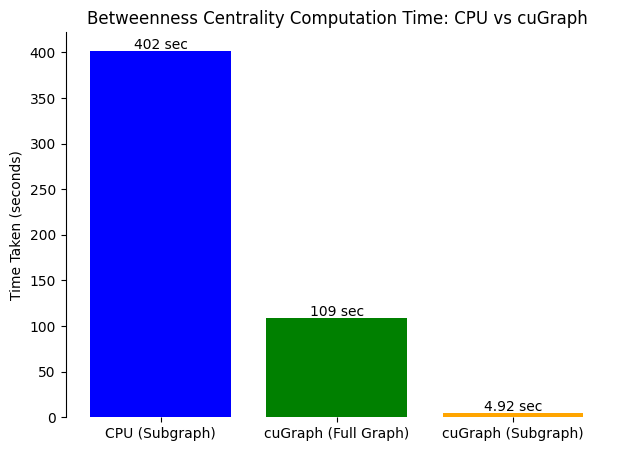

In [ ]:
methods = ["CPU (Subgraph)", "cuGraph (Full Graph)", "cuGraph (Subgraph)"]
times = [wall_time_cpu, wall_time_cugraph, wall_time_cugraph_sub]

# Create bar chart
plt.figure(figsize=(7, 5))
plt.bar(methods, times, color=['blue', 'green', 'orange'])

# Labels and title
plt.ylabel("Time Taken (seconds)")
plt.title("Betweenness Centrality Computation Time: CPU vs cuGraph")

# Remove grid lines completely
plt.grid(False)

# Remove x-axis line and other unnecessary spines
ax = plt.gca()
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)  # Keep left spine for reference

# Show values on bars
for i, v in enumerate(times):
    plt.text(i, v + 2, f"{v} sec", ha='center', fontsize=10)

# Show plot
plt.show()

**Analysis of Betweenness Centrality Computation**

- Using NetworkX (CPU) on the subgraph took 4× more time than cuGraph (GPU) on the full graph and a staggering 81× more time than cuGraph on the same subgraph.
- Meanwhile, cuGraph on the full graph took 22× more time than on the subgraph, even though the full graph had 8× more nodes and 31× more edges.
- This demonstrates that cuGraph scales far better than the CPU-based NetworkX backend, making it significantly more efficient for large graphs.



## Interface

In [ ]:
# Uncomment this lines if facing an error with pip install
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
pip install streamlit plotly --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/QasimKhan5x/GDELT-AQL-NetworkX-Agent
%cd GDELT-AQL-NetworkX-Agent
!npm install localtunnel
!cp /content/drive/MyDrive/gdelt.pickle /content/drive/MyDrive/gdelt_und.pickle ../cert_file.crt .

fatal: destination path 'GDELT-AQL-NetworkX-Agent' already exists and is not an empty directory.
/content/GDELT-AQL-NetworkX-Agent
⠙⠹⠸⠼⠴⠦
up to date, audited 23 packages in 842ms
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦
2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠦

Paste the IPv4 address into the password field in the webpage

In [ ]:
!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.198.236.193
⠙your url is: https://fair-poets-fail.loca.lt


In [ ]:
%cd ..
!rm -rf GDELT-AQL-NetworkX-Agent

/content
